rossler1d
H shape: (102, 2000)
idx: 0 MSE: 4.545939647077796e-06
('ESN', <ModelType.ESN: 2>, {'reservoirConf': {'alpha': 0.9, 'connectivity': 1, 'nz': 100, 'nu': 1, 'target_rho': 0.99, 'input_scale': 1}, 'encoder': 'transform'})
H shape: (102, 2000)


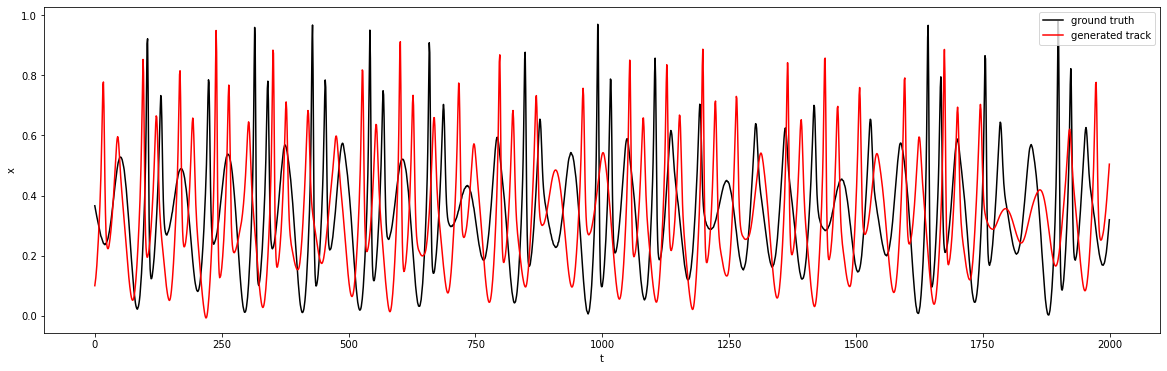

rabinovich_fabrikant1d
H shape: (102, 2000)
idx: 0 MSE: 3.5824698019874943e-06
('ESN', <ModelType.ESN: 2>, {'reservoirConf': {'alpha': 0.9, 'connectivity': 1, 'nz': 100, 'nu': 1, 'target_rho': 0.99, 'input_scale': 1}, 'encoder': 'transform'})
H shape: (102, 2000)


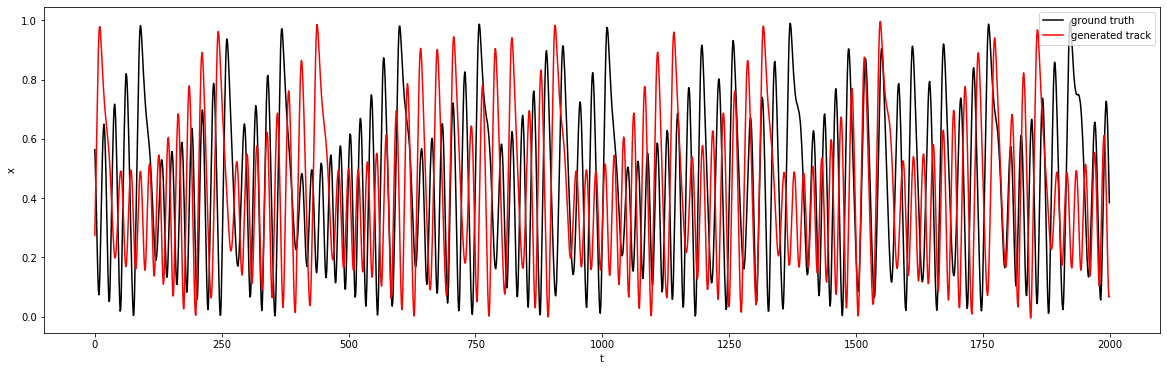

lorentz1d
H shape: (102, 2000)
idx: 0 MSE: 1.0191049771220519e-05
('ESN', <ModelType.ESN: 2>, {'reservoirConf': {'alpha': 0.9, 'connectivity': 1, 'nz': 100, 'nu': 1, 'target_rho': 0.99, 'input_scale': 1}, 'encoder': 'transform'})
H shape: (102, 2000)


OverflowError: cannot convert float infinity to integer

<Figure size 1440x432 with 1 Axes>

chua1d
H shape: (102, 2000)
idx: 0 MSE: 2.1574894049446523e-05
('ESN', <ModelType.ESN: 2>, {'reservoirConf': {'alpha': 0.9, 'connectivity': 1, 'nz': 100, 'nu': 1, 'target_rho': 0.99, 'input_scale': 1}, 'encoder': 'transform'})
H shape: (102, 2000)


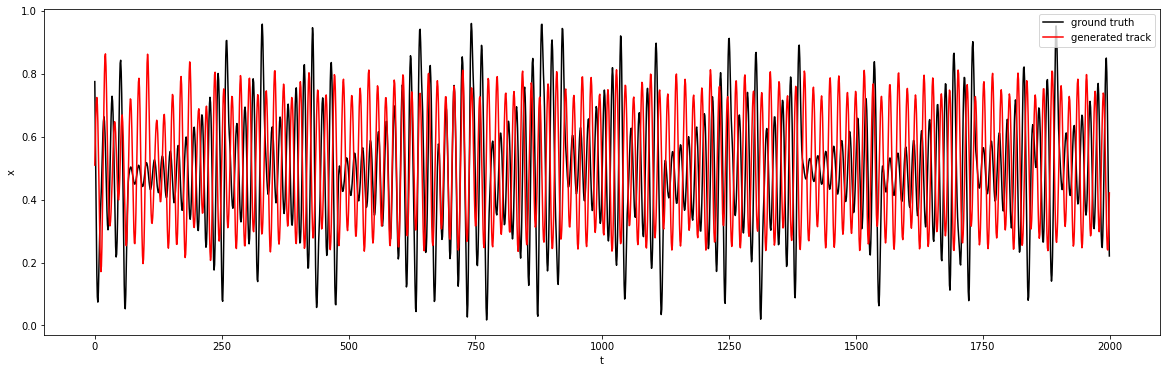

In [5]:

# !/usr/bin/env python
# -*- coding: utf-8 -*-

from nolds.measures import poly_fit
from nolitsa import data, lyapunov
from nolitsa.d2 import *
import numpy as np
import matplotlib.pyplot as plt
from RBFNN import *
from dataset.chaotic_system import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
from utils import *

class Dict(dict):
    __setattr__ = dict.__setitem__
    __getattr__ = dict.__getitem__


names = [
    'rossler',
    'rabinovich_fabrikant',
    'lorentz',
    'chua',
]
names = [n + '1d' for n in names]

n_dim = 1
horizon = 1
N = 10000
n_history = 100  # 使用 n 个历史点作为输入
N_h = 200
num_prepare = 1000
num_train = 2000
num_test = 2000
train_start = 0
test_start = 5000
np.random.seed()
nz = 100
connectivity = 1
reservoirConf = Dict(
    alpha=0.9,
    connectivity= connectivity,
    nz= nz,
    nu = n_dim,
    target_rho=0.99,
    input_scale= 1
)



def gen_model(conf):
    _, model_type, kwargs = conf
    conf_dict = dict(
        model_type=model_type,
        **kwargs
    )
    return RBFNN(**conf_dict)


for system_name in names:
    print(system_name)
    '''
    数据集
    '''
    x = np.loadtxt('dataset/'+system_name+'.txt', delimiter=',').T
    x += np.random.randn(*x.shape)*0.001

    x_train = np.vstack([select_samples(x, train_start + i, num_train + num_prepare) for i in range(n_history)])
    x_test = np.vstack([select_samples(x, test_start + i, num_test + num_prepare) for i in range(n_history)])
    y_test = select_samples(x, test_start + num_prepare + n_history + horizon - 1, num_test)
    y_train = select_samples(x, train_start + num_prepare + n_history + horizon - 1, num_train)
    # plt.figure()
    # plt.plot(x_test[:, num_prepare:].T, label='x')
    # plt.plot(y_test.T, label='y')
    # plt.legend()
    # plt.show()


    model_confs = []
    model_confs += [('ESN', ModelType.ESN, dict(reservoirConf=reservoirConf, encoder='transform'))]
    # model_confs += [('RBFLN-RE-transform', ModelType.RBFLN_RE, dict(N_h=N_h, sigma=sigma, reservoirConf=reservoirConf, encoder='transform'))
    #     for sigma in [1 / 8, 1 / 4, 1 / 2, 1, 2, 4, 8]]
#     model_confs += [('RBFLN-RE-echostate', ModelType.RBFLN_RE, dict(N_h=N_h, sigma=sigma, reservoirConf=reservoirConf, encoder='echostate'))
#         for sigma in [1 / 8, 1 / 4, 1 / 2, 1, 2, 4, 8]]
    # model_confs += [('ESN-ATTN', ModelType.ESN_ATTN, dict(N_h=N_h, sigma=sigma, reservoirConf=reservoirConf))
    #                 for sigma in [1 / 8, 1 / 4, 1 / 2, 1, 2, 4, 8]]



    Predictions = [np.empty((n_dim, num_test)) for _ in range(len(model_confs))]
    MSE = [0.0] * len(model_confs)

    for j, conf in enumerate(model_confs):
        model = gen_model(conf)
        model.train(x_train, y_train, num_prepare)
        Predictions[j] = model.predict(x_test, num_prepare)
        MSE[j] = mse(Predictions[j], y_test)
        print('idx: {} MSE: {}'.format(j, MSE[j]))

    best_model = model_confs[np.argmin(MSE)]
    print(best_model)
    model = gen_model(best_model)
    model.train(x_train, y_train, num_prepare)
#     y_pred = model.predict_multistep_esn(x_test[:,:num_prepare+1], num_test)
    y_pred = model.predict_multistep(x_test[:, num_prepare+1000:num_prepare+1000+1], num_test)
    y_pred = y_pred.reshape((num_test,n_dim)).T

#     np.savetxt(system_name + '_pred.txt', y_pred.T, fmt='%.8e', delimiter=',')
#     np.savetxt(system_name + '_test.txt', y_test.T, fmt='%.8e', delimiter=',')

    # fig = plt.figure(figsize=(6, 6))
    # ax = fig.add_subplot(111, projection='3d')
    # elev, azim = 30, -45
    # ax.view_init(elev, azim)
    # plt.plot(*y_test, 'g', label='ground truth')
    # plt.plot(*y_pred, 'r', label='generated track')
    # plt.plot(*y_test[:,:1], 'ko', label='initial point')
    # plt.xlabel('x')
    # plt.ylabel('y')
    # plt.legend(loc='upper right')
    # plt.savefig(system_name + '_replicate.pdf')


    plt.figure(figsize=(20, 6))
    dim = ['x', 'y', 'z']
    for i in range(n_dim):
        plt.subplot(n_dim, 1, i + 1)
        plt.plot(y_test[i].T, color='black', label='ground truth')
        plt.plot(y_pred[i].T, color='red', label='generated track')
        plt.ylabel(dim[i])
        if i == 0:
            plt.legend(loc='upper right')
    plt.xlabel('t')
    # plt.savefig(system_name + '_replicate_dim.pdf')
    plt.show()


    # y_gen = model.predict_multistep(x_train[:,:1], x.shape[-1])
    # y_gen = y_gen.reshape((-1, n_dim)).T

    plt.show()









In [ ]:
def CD(x):
    r, c = c2(x,  metric='euclidean')
    r, c = np.log(r), np.log(c)
    coefs = poly_fit(r, c, 1)
    print('LLE = ', coefs[0])

    plt.figure()
    plt.title('corr sum for the '+system_name)
    plt.xlabel(r'Time $t$')
    plt.ylabel(r'Average divergence $\langle d_i(t) \rangle$')
    plt.plot(r, c, label='divergence')
    plt.plot(r, coefs[1] + coefs[0] * r, '--', label='RANSAC')
    plt.legend()
    # plt.show()
    # d1 = d2(r, c)
    return coefs[0]


def LLE(x):
    dt = 0.01
    meanperiod = 10
    maxt = 150
    # d = lyapunov.mle(x, maxt=maxt, window=meanperiod)
    d = lyapunov.mle_embed(np.squeeze(x), dim=[5], maxt=maxt, window=meanperiod, parallel=False)
    d = np.squeeze(d)
    t = np.arange(maxt) * dt
    coefs = poly_fit(t, d, 1)
    print('LLE = ', coefs[0])

    plt.figure()
    plt.title('Maximum Lyapunov exponent for the '+system_name)
    plt.xlabel(r'Time $t$')
    plt.ylabel(r'Average divergence $\langle d_i(t) \rangle$')
    plt.plot(t, d, label='divergence')
    plt.plot(t, coefs[1] + coefs[0] * t, '--', label='RANSAC')
    plt.legend()
    # plt.show()

    return coefs[0]


print('LLE test:', LLE(y_test.T))
print('LLE pred:', LLE(y_pred.T))
#
# print('CD test:', CD(x.T))
# print('CD pred:', CD(y_gen.T))
print('CD test:', CD(y_test.T))
print('CD pred:', CD(y_pred.T))